In [20]:
from __future__ import print_function, division
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import warnings
warnings.filterwarnings('ignore')

In [29]:
# constant variable to re-size all the images to this size
IMAGE_SIZE = [256, 256] 

# training configuration:
epochs = 10
batch_size = 32

train_path = 'Data'
valid_path = 'Test'

In [30]:
# File reading and path confiuration to get count of classes

image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

folders = glob(train_path + '/*')

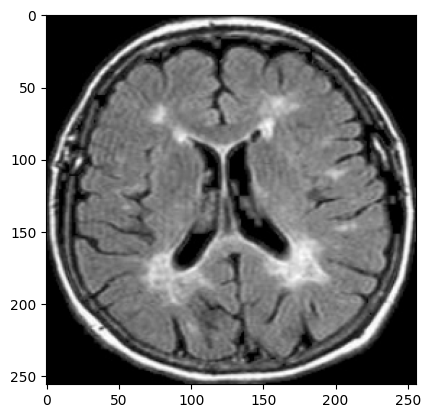

In [31]:
# Sample Image
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [32]:
# Imported a single fully connected layer VGG with 5 pooling layers and 13 convolutional layers

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [33]:
# create an instance of ImageDataGenerator to load images and apply size transformations
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 100 images belonging to 4 classes.
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.68 max: 148.98248


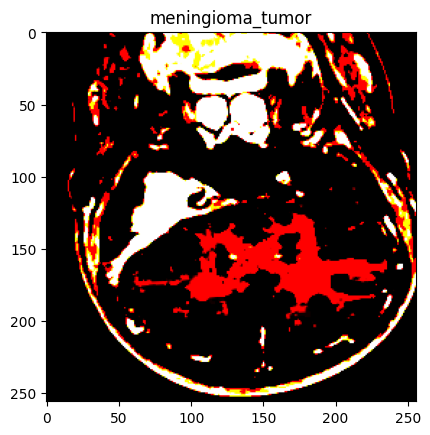

In [36]:
# after preprocessing using the VGG model's preprocessing function produces
# strangely colored image (due to VGG weights being BGR)

for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [37]:
# create generators to load data in batches

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 1888 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [38]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/10
59/59 [==============================] - 286s 5s/step - loss: 17.1459 - accuracy: 0.5757 - val_loss: 7.4542 - val_accuracy: 0.7604
Epoch 2/10
59/59 [==============================] - 324s 5s/step - loss: 9.2025 - accuracy: 0.7150 - val_loss: 4.6602 - val_accuracy: 0.8229
Epoch 3/10
59/59 [==============================] - 317s 5s/step - loss: 8.7983 - accuracy: 0.7558 - val_loss: 6.4662 - val_accuracy: 0.7708
Epoch 4/10
59/59 [==============================] - 312s 5s/step - loss: 7.1161 - accuracy: 0.8040 - val_loss: 17.7061 - val_accuracy: 0.7188
Epoch 5/10
59/59 [==============================] - 304s 5s/step - loss: 6.9200 - accuracy: 0.7950 - val_loss: 8.5140 - val_accuracy: 0.8333
Epoch 6/10
59/59 [==============================] - 304s 5s/step - loss: 6.4311 - accuracy: 0.8178 - val_loss: 4.9294 - val_accuracy: 0.8750
Epoch 7/10
59/59 [==============================] - 303s 5s/step - loss: 6.0914 - accuracy: 0.8400 - val_loss: 6.1344 - val_accuracy: 0.8229
Epoch 8/10


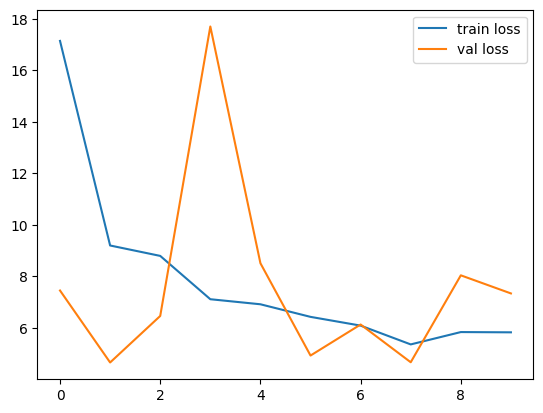

In [39]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

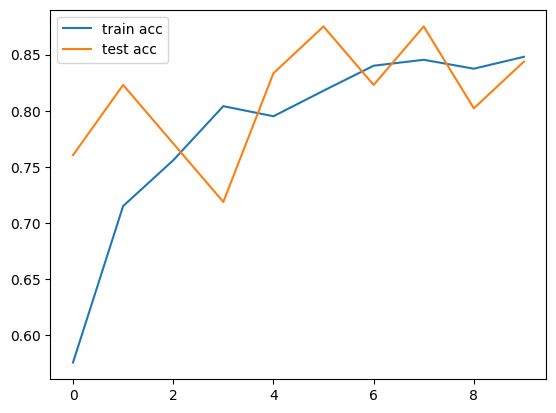

In [40]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()